# DATA-SCIENCE Proyecto 3
## Benjamin Abraham Nieto
### "Sistema de Recomendacion"

## Proposito
El proposito de este proyecto es poder implementar una solucion a un sistema de recomendacion el cual debera ser capaz de darnos una sugerencia de videojuego deacuerdo a los juegos que ya hallamos jugado y tambien que otros usuarios similares a nosotros hayan jugado (filtro colaborativo).

Posteriormente la idea es poder implementar dicho sistema de recomendacion e una aplicacion real donde usuarios puedan usar este servicio como parte de una paltaforma.

### Objetivos
Los objetivos a buscar seran los siguientes:
- Desarollo de sistema de recomendacion
    - Optimizacion de datos
    - Uso de datos en el sistema de recoemdacion
    - Desarrollo de modelo
    - Prueba de modelo
    - Desarrollo de Algoritmo de recomendacion
    - Implementacion

### Analisis Exploratorio
Como primera parte del desarrollo de este sistema vamos a ver los datos que tenemos y de que forma podemos usarlos.

#### Datos Provistos
Esperamos en el dataset encontrar varios tipos de datos de los cuales los mas importantes serian:
- Usuarios (id o gametag): Esperamos estos datos porque de alguna maera necesitamos tener las caracteristicas de un usuario, de otra manera no podriamos saber que usuario desea que o a quien recomendar.

- Videojuego: Ya que nuestro sistema tiene como objetivo la recomendacion de videojuegos, lo que se pretende es que la aplicacion no nos genere solo algun numero sino que pueda darnos algo que el usuario que use este sistema pueda entender, ene este caso sera el nombre o la informacion de un videojuego.

- Score/Putuaciones: No debe ser un secreto que busquemos encontrar puntuaciones ya que la base muchos sistemas de recomendacion (este tambien) son las puntuaciones de los items con los que cuenta, ya que de algua manera tendremos que indicarle al algoritmo a desarrollar como saber si recomendarnos o no un juego.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import gzip
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
contador = 0
data_reviews = []
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1


In [4]:
data_reviews = pd.DataFrame(data_reviews)

## Data Reviews

Como primera parte podemos ver que el dataset viene dividido en dos, como primera parte tenemos las reviews donde extrayendo una fraccion de estos es notable el hecho de que hay varios idiomas presentes y valores faltantes por lo cual mas adelante talves sera necesario el uso de imputacion de valores faltantes y el diseño de un algoritmo para evaluar las reseñas.

In [7]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


### Dataset Reviews
Nuestro dataset de reviews contiene 12 columnas y mas de **700,000** filas por lo que tenemos mucho material para trabajar
Viendo las columnas podemos emepzar a darle cierta importancia a algunos de los datos con los que contamos, lo cuales son:
- hours
- text (la review)
- compesation*
- found_funny

In [5]:
data_desc = data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   username      779307 non-null  object 
 1   hours         776670 non-null  float64
 2   products      777741 non-null  float64
 3   product_id    779307 non-null  object 
 4   page_order    779307 non-null  int64  
 5   date          779307 non-null  object 
 6   text          779307 non-null  object 
 7   early_access  779307 non-null  bool   
 8   page          779307 non-null  int64  
 9   user_id       317340 non-null  object 
 10  compensation  14588 non-null   object 
 11  found_funny   120164 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 66.1+ MB


#### Datos dataset "Reviews"
Antes de definir la manera en la que pueden ser usados los datos, lo primero que podemos observar es el tipo de dato y con cuantos contamos de cada uno para asi de una vez definir si seran utiles y porque.

Todos los datos pueden ofrecer de alguna manera informacion valiosa pero los que vamos a usar en esta ocasion solo seran algunos, para empezar 
- a) La mayoria de los datos con los que contamos son de tipo 'object' lo que significa que si deseamos hacer las evaluaci9ones y desarrollo del modelo apartir de estas, se necesaritaran proces diferentes para convertir estos datos a datos mas manejables como los numericos, aunque cabe destacar que por ahora la mayoria de los datos de tipo 'object'  no seran la prioridad para abordar el problema.

- b) Los datos necesarios para realizar la 'estrcutura' del modelo son numericos y en este caso , datos como "hours" seran utiles y teniendo la ventaja de que son numericos eso nos puede dar una ventaja para manipularlos.

- c) Por otro lado nos encontramos la situacion que no exite ningun dato como tal asociado a la puntuacion por lo que tendremos que generalo de algun modo, eso por un lado es bueno ya que podemos generar el tipo de dato que mas se acomode a nuestras necesidades, por otra parte exite el problema de que debemos tener cuidado al generar este dato porque puede afectar totalemnte los resultados del modelo ya que segun lo que veremos es una dato importante 

#### ¿Que pueden ofrecer estos datos?

**"hours"**:Las horas indican el tiempo que dedico el jugador a determinado juego, lo cual puede ser un buen indicador para saber si a un usuario le agrado un juego o no, este dato puede ser importante.

**"text"**:Es la review del videojugo lo cual puede arrojarnos luz sobre lo que piensan los usuarios de cada juego, por lo que sera importante buscar palabras claves y hacer asociaciones para poder introducir a un algoritmo.

**"compensation"**:Nos muestra si el juego en cuestion ofrecia algo, es decir, si hbia devoluciones, si era gratis o tenia alguna oferta especial, con esto podriamos ver si un juego era popular por el precio o si talves usaron alguna estrategia de marketing para vender el juego a los jugadores.

**"found_funny"**:En teoria este campo en particular deberia darnos la pista mas grande de los juegos pero como vimos en nuestro "head" hay valores faltantes lo cual probalmente no nos diga mucho pero podria hacerlo despues.

### Distribucion de Variables
En los siguientes graficos exploraremos algunas de las variables para ver como es su comportamiento en el dataset:
 1) **'hours'**: Esta variable en particular podria resultar util en caso de que found funny no pueda darnos informacion tan relevante, en este caso, en el eje y tenemos la cantidad de filas de neustro data set la cual representa a cada usuario o mejor dicho cada opinion que se encuentra en el dataset y en el eje x vemos las horas jugadas. 
 
En este caso filtramos las horas para apreciar mejor la distribucion, donde vemos que la mayoria del tiempo jugado con el que cuentan nuestros usuarios no suele superar las 100 horas de juego, esto puede ser importanta ya que apartir de las horas de juego podriamos determinar la preferencia de un usuario por un juego u otro.

<AxesSubplot:xlabel='hours', ylabel='Count'>

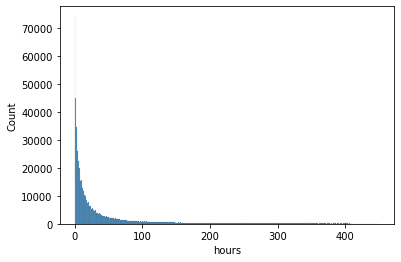

In [20]:
filter_ph = data_reviews[(data_reviews['hours'] <= 450)]
sns.histplot(filter_ph.hours)

Anteriormente mencionabamos que el dato **'found_funny'** pudo ser el dato mas importante sin embargo tenemos un problema y es que tenemos muchos datos faltante, demasiados como para poder utilizarlo o imputar valores sin sesgar los resultados del modelo.

Otro punto a destacar es que la mayorias de las "puntuaciones" son bajas, lo cual definitivamente generaria valores nefativos si lo agregamos a un algoritmo, necesitariamos que la distribucion fuera mas uniforme para poder imputar valores y tener mas datos para hacerlo tambien.

<AxesSubplot:xlabel='found_funny', ylabel='Count'>

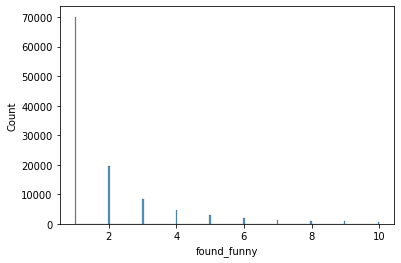

In [23]:
filter_ff = data_reviews[(data_reviews['found_funny'] <= 10)]
sns.histplot(filter_ff.found_funny)

Tambien como dato extra decidimos analizar los videojuegos para saber si hay alguno en particular con mas reseñas, esto porque si hay muchas reseñas de un juego, seria dificil dar un resultado para otro tipo de juegos, tambien nos diria si hay algun juego popular o de que manera usar utilizar los datos de un juego si es uq tuviera demasiados.

Observaando estos graficos nos encontramos que el juego con mayor cantidad apenas son el 2% de las reseñas lo cual en realidad no es nada auque no esta demas vigilar ese juego para ver que tiene de especial.

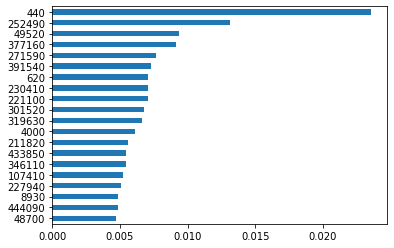

In [15]:
data_reviews['product_id'].value_counts(ascending=True, normalize=True).tail(20).plot.barh()
plt.show()

### Analisis Preeliminar Dataset Reviews
Ahora analizamos los valores faltantes de cada columna que nos da este data set:
1) Como se esperaba los datos de **"found_funny"** y **"compensation"** tienen la mayoria de sus valores faltando por lo que es casi imposible hacer una imputacion de valores, asi que qeudan eliminados como datos a tomar en cuenta.

2) Por otro lado tenemos **"hours"** que tambien tenemos pensado usar y vemos que solo tiene ***2,633*** valores faltantes lo cual no es ni el 1% de los datos de esa columna por lo cual podremos imputar algunos valores o simplemente descartarlos.

3) Por ultimo **"products"** y **"user_id"** son dos columnas que no nos interesan demasiado ahora por lo cual no hay problema en que tengan demasiados valores faltantes.

In [14]:
data_reviews.isna().sum()

username             0
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text                 0
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

## Data Games

In [5]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

Esta es la seccion de los juegos donde estan los datos de cada juego y podemos clasificarlos de varias maneras, por desarrolldor, genero, precios etc.
Al igual que como se hizo anteriormente la idea es observar los datos con los que contamos para encontrar una manera de proceder.

In [10]:
data_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


### Dataset Games
Este dataset contiene 16 columnas mas de **30,000** filas por lo que tenemos muchas menos que las review pero para lo que requerimos solo necesitamos que se encuntren todos los juegos de los quetenemos reviews y usaremos esta informacion de manera ligeramente disitinta.

Los datos con lo que contamos y daremos importancia son:
- publisher
- genres
- app_name & title
- tags 
- specs
- developer
- sentiment

In [8]:
data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


#### Datos Dataset Games
En nuestro segundo dataset que nos da una descripcion mas detallada sobre el producto en cuestion a recomendar, los videojuegos, podemos apreciar menos cosas pero aun asi importantes

- a) La mayoria de los datos con los que contamos son de tipo 'object'  lo que significa que en su mayoria estos datos seria dificiles de trabajar en especial si queremos que sean parte escencial de nuestro modelo, aunque si miramos bien los datos con los que contamos la mayoria de ellos no nos aportan datos relevantes para la creacion o entrenamiento del sistema de recomendacion por lo cual no representa un problema que vengan en este formato.

- b)Este dataset es mas pequeño que el anterior y si observamos los datos que tenemos podemos notar que contamos con la mayoria de cada unos sabiendo que el dataset tiene **32,135** filas y contamos con almenos 24,000 de cada dato, es decir tenemos alemos el 75% de cada uno de los datos en este dataset.

#### ¿Que pueden ofrecer estos datos?

**"publisher"**: Podemos usar este dato para relacionar a un jugador y sus gustos, con los juegos de una compañia que normalmente tienen varios juegos parecidos o desarrollan sagas.

**"genres"**: Los generos tambien pueden indicar si un usuario tiene preferencia por este tipo de juegos o podemos recomendar en base al genero, es dedcir buscar los mejores juegos de "Shooting", "Adventures" etc.

**"app_name & title"**: Es el nombre del juego y podemos hacer recomendaciones en base a lo que la gente opina de un juego en particular o si en una futura aplicacion el usuario tiene como contaacto un usuario que puntuo el juego de manera positiva podria servir como referencia.

**"tags"**:Los tags son la categorias de un juego lo cual puede servirnos como se menciono, para hacer recomendaciones deacuerdo a los generos.

**"specs"**: Son las modalidades de lo juegos es edcir, "Single Player", " Online" etc y en general lo podemos usar para recomendar en base a este filtro.

**"developer"**: Tiene un funcion muy parecida a publisher sin embargo cuenta con la ventaja de que el estudio que desarrolla ciertos videojuegos muchas veces tiene la fama de que los juegos tienen particularidaes especificas de cada desarrollador, como pueden ser lo graficos, posibilidades, historias etc, datos de los cuales podemos sacar partido esperando que la recomendacion tenga implicto estas cosas.

**"sentiment"**: Si bien desearimos usar este dato como indicador para recomendar un juego, es probale que como vimos anteriormente halla muchos valores faltantes pero en caso contrario sera util para saber como ven los jugadores un juego en particular.


### Analsis preeliminar Dataset Games
Vemos los valores faltantes en este dataset para saber como proceder:

1) Tenemos algunos valores faltantes en **publisher** pero hay posibilida de imputarlos con **developer** o usar developer en su lugar.

2) Tambien tenemos valores faltantes con **genres** pero podemos usar **tags** para imputar o sustituir y probalemnte no habra mucha diferencia.

3) En **title** tenemos valores faltanes pero podemos analizar la posibilidad de susituir por **app_name**.

4) **specs** tiene valores faltantes pero probablemnte no sera problema tratar con ellos, incluso podriamos relacionar los specs con el genero para conocer las posibilidades del juego.

5) Para developer sera necesario ver mas los datos para saber como imputar o si es posiblem completar los datos de otras formas.

6) Tambien hay muchos valores faltantes para sentiment por lo cual habra que hacer mas revisiones y de esa manera buscar una solucion para los valores faltantes.

In [12]:
data_games.isna().sum()

publisher          8052
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29458
dtype: int64

## Transformacion de Dataset's
 Ya que sabemos con que datos contamos procedere a darle forma  a ambos dataset's para poder trabajar con  los datos que poseemos

In [6]:
data_review_v1 = data_reviews.drop(['compensation', 'found_funny','page','early_access'], axis=1)
most_played = data_review_v1.loc[:, 'hours'] >= 12
gamer = data_review_v1.loc[most_played]
gamer_data=gamer.assign(score=5)
gamer_data.head()

,username,hours,products,product_id,page_order,date,text,user_id,score
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,NaN,5
8,rampage1209,34.8,3.0,1840,4,2018-01-04,WAY PAST COOL,76561198080474371,5
13,Sir Dan the Super Chivalrous,27.0,16.0,506510,5,2017-12-19,is more than a love letter to SNES era RPGS. T...,NaN,5
21,jimbofal,34.6,14.0,365560,2,2017-01-01,It would be nice if there was a way to acknowl...,76561198030607371,5
25,Mia,31.4,149.0,631920,3,2017-09-14,What a cute little game! The puzzles are actua...,NaN,5


In [7]:
least_played = data_review_v1.loc[:, 'hours'] < 12
proved = data_review_v1.loc[least_played]
bad_data=proved.assign(score=1)
bad_data.head()

,username,hours,products,product_id,page_order,date,text,user_id,score
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,NaN,1
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,NaN,1
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,76561198003030375,1
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",76561198353396844,1
5,Szudof,0.2,155.0,288690,0,2016-08-31,"<23:32:55> ""Pit"": Hello, my name is dominik di...",NaN,1


In [8]:
game_score_data = pd.concat([gamer_data, bad_data], axis=0)
game_score_data

,username,hours,products,product_id,page_order,date,text,user_id,score
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,NaN,5
8,rampage1209,34.8,3.0,1840,4,2018-01-04,WAY PAST COOL,76561198080474371,5
13,Sir Dan the Super Chivalrous,27.0,16.0,506510,5,2017-12-19,is more than a love letter to SNES era RPGS. T...,NaN,5
21,jimbofal,34.6,14.0,365560,2,2017-01-01,It would be nice if there was a way to acknowl...,76561198030607371,5
25,Mia,31.4,149.0,631920,3,2017-09-14,What a cute little game! The puzzles are actua...,NaN,5
...,...,...,...,...,...,...,...,...,...
779240,No Monitor,11.6,44.0,252490,1,2013-12-15,pretty cool. Dongers came in like a recking ba...,76561198022695554,1
779241,Yo Tengo Un Flow Cabron,1.3,69.0,252490,1,2013-12-15,"Good game, but it needs to be more optimised, ...",NaN,1
779244,Finkly,7.2,295.0,252490,1,2013-12-15,its ok but its not worth 20$ and its very laggy,76561198049828110,1
779298,Slavic Psycho,3.9,135.0,252490,1,2013-12-11,never seen anything like this,NaN,1


En este caso a diferencia de un problema de regresion no podemos buscar relacion entre columnas o datos porque obtendremos una relacion muy baja o nula ya que por si mismos estos datos no tienen relacion alguna, por lo que abordaremos este problema desde otro punto de vista donde integraremos el procesamineto de lenguaje y matematicas para generar numeros que podamos asociar a algo "positivo" o "negativo" y nuestro sistema pueda recomendar.

(Antes de intentar dar una prediccion antravez de los comentarios usaremos algo mas simple, deacuerdo a las horas de juego daremos una puntuacion provicional)

En este punto hay algunas preguntas que intentaremos contestar:
1) ¿Sera posible usar los textos de las reseñas?

2) ¿De que manera podemos convertir en puntuaciones los textos?

3) ¿Es practico realizar esto para conseguir puntuaciones?¿Por que?

### NLP 
Ya que no tenemos en nuestro dataset un conjunto de datos como "score", "raiting" o algo parecido usaremos las reseñas de los usuarios para obtener una puntuacion simple que nos indique si a un usuario le gusto un videojuego o no en base las palabras que este escribio.

In [7]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Lo primero a hacer es crear un algoritmo para reconocer los sentimientos en una opinion.

Pero **¿Como identificar los "sentimientos"?**

Como tal no es posible identificar un sentimineto  o intencion en una oracion sin embargo los lenguajes humanos funcioann por etructuras y en esas estructuras los componentes son lo que podria decirnos que intencion hay en una frase.

En este caso para idetificar los "sentimientos" vamos a buscar los **adjetivos** que normalmente usamos para describir algo, y es con este tipo de palabras que podemos darnos una idea de que piensa una persona respectoa a algo, en este caso sobre un juego.


In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stop_words = list(stopwords.words('english'))


In [24]:
def scoreGenerator():
    adjetives=[]
    review = data_review_v1.iloc[0, 6]
    if detect(review) == 'en':    
        tokenized_review = word_tokenize(review)
        tagging_review = nltk.pos_tag(tokenized_review)
        for element in tagging_review:
            if element[1] == 'JJ' or element[1] == 'JJR' or element[1] == 'JJS':
                adjetives.append(element[0])
        
    
    return adjetives
            
        
print(scoreGenerator())

['acceptable']


Hasta ahora podemos ver que es posible reconocer un adjetivo y desde este punto podemos asociar ciertos adjetivos a una emocion pero aqui sucede algo que normalmente encontramos al explorar mas el dataset.

Mucha gente para expresar opinionenes usa emoticosnes que podriamos traducirlos de igual manera a una emocion sin embargo otros susarios tambien usan expresiones como "!Ohhh¡" o "!Ohh...¡" que lucen casi exactamente igual, lo cual nustro algortimo necesitaria aprender este tipo de expresiones para asociarlas a un sentimineto.

Si bien estos podrian ser los impedimentos mas grandes para hacerlo podemos ocupar el algoritmo con una par de mejoras extra pero esta vez lo dejaremos como un punto a mejorar proximamente y usaremos las puntuaciones que generamos para agilizar los resultados.

In [9]:
data_games.drop(['metascore'],axis=1)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.49,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",NaN
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",4.24,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,NaN
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",1.39,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,NaN
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",NaN,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",1 user reviews


## Sistema de Recomendacion 
### Primera visualizacion

**¿Como funciona el sistema de recomendacion?**
Lo primero a entender es que nuestro sistema funciona a base de "matrices" es decir, los dataset donde se encuentran nuestros datos son una matriz pero como se mencionaba anteriormente, no todos los datos son utiles para lo que queremos hacer, en este caso.

In [10]:
from surprise import Dataset
from surprise import Reader
#═══════════ SVD ═══════════ 
from surprise import SVD
from surprise.model_selection import cross_validate

La matriz que usaremos esta compuesta por tres datos, **'username' o 'user_id', 'product_id' y 'score'**, la razon que esto es que nuestro sistema de recomendacion funciona con las puntuaciones de los usuarios que nostros dimos, asi que ,lo que nuestro sistema hara es decirnos que calificacion podria dar un usuario en especifico a un videojuego en especifico. 

In [11]:
reader = Reader(rating_scale = (1,5))
matricial_data = Dataset.load_from_df(game_score_data[['username', 'product_id', 'score']], reader)

## Modelos de Sistema de Recomendacion

### A) Predictor Slope One (SlopeOne) 
Esencialmente, en vez de usar una regresión lineal de las valoraciones de un elemento para las valoraciones de otro, se usa una forma simple de regresión con un solo parámetro.
El parámetro indicado es entonces una diferencia de promedio entre la valoración de dos elementos. 
Esto ha demostrado ser mucho más exacto que la regresión lineal en algunas instancias, y toma la mitad del espacio de almacenamiento o menos.
### B) Factorizacion de Matriz non-Negativa (NMF)
NMF es un algoritmo de minería de datos potente y actual que se puede usar para una amplia variedad de casos.
Como SVD, descompone una matriz M como UDV'. Solo que, en este caso, las entradas de M son todas positivas. Y la descomposición es UV', donde las entradas de ambas matrices son también positivas, tambien es similar al análisis de componentes principales. (PCA) pero puede gestionar un mayor número de atributos.

### C) Descomposicion en Valores Singulares (SVD)
El SVD es una tecnica de factorizacion de matrices para descomponer una matriz (A) en otras (S, V, U) de tal forma que el producto matricial de estas nos devuelva nuestra matriz inicial.

**¿Porque esto es importante?**
SVD tiene una propiedad importante que la hace buena para trabajar sistemas de recomendacion y tambien otras areas, y es que al reducir los valores singulares de la matriz S (recordando que la matriz 'A' se convierte en otras matrices),a los primeros ***k*** valores, se obtiene una aproximacion de la matriz original, esto permitira que la recontruyamos a partir de las versiones reducidas de las matrices aunque con un pequeño error pero con las dimensiones de las matrices reducidas.


Esta transformacion de los datos originales, es decir nuestra matriz sin ser transformada, resulta en una represnetacion reducida de los mismos datos pero en dimension ***k***, lo cual es muy util ya que en este caso en particular estamos hablando de una matriz de mas de 700,000 datos, y si no hicieramos niguna transformacion obtendriamos 3 matrices con dimensiones similares.

Pero al hacerlo de manera SVD y con la reduccion de dimensionaliad tendriamos una aprosimacion buena a la matriz original reduciendo tambien y de manera significativa el tiempo de computo para el calculo de las matrices, necesitanfo asi mismo, menos menoria para almacenar esta informacion.


#### Sistema de Recomendacion y SVD
**¿Que buscamos al realizar SVD sobre nuestra matriz con votos?**
La idea de un sistema de recoemdacion basado en filtro colaborativo es tomar los puntajes de diferentes usuarios, lo cual despues de aplicar SVD nos dara una serie de factores que caractericen a cada usuario e item del sitema, una vez con esta caracterizacion podemos predecir de muy buena manera los items, en este caso videojuegos, que no han sido votados.





In [24]:
from surprise import KNNBasic, NMF, KNNWithMeans, SlopeOne
benchmark=[]

for model in [SVD(), NMF(),SlopeOne()]:
    results = cross_validate(model, matricial_data, measures=['RMSE'], cv=3, verbose=False)

    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(model).split(' ')[0].split('.')[-1]], index=['Model']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Model').sort_values('test_rmse')

,test_rmse,fit_time,test_time
Model,,,
SVD,1.640484,39.574376,3.024334
NMF,1.980096,74.566206,2.764001
SlopeOne,2.059256,11.084332,3.813668


### Metricas de Evaluacion
Para evaluar nuestro modelo podemos usar cualquier metrica para problemas de regresion, en este caso usaremos "RSME" y "MAE", aunque un punto importante a mencionar es que las metricas como RMSE puden penalizar al modelo por predecir mas calificaciones altas. 

- #### RMSE
Con RMSE representamos básicamente la desviación estándar de las diferencias entre los valores estimados y los valores reales. Se define como la raíz cuadrada de la diferencia entre la predicción del rating y su valor real al cuadrado.

**¿Que resultado esperamos con 'RMSE'?**
Despues de haber evaluado los modelos podemos ver cual es el que mejor se adecua, con los datos que tenemos claro, a lo que queremos hacer, lo cual es hacer predicciones a un usuario acerca de que videojuegos podrian gustarle, justamente atravez de uno de nuestros algoritmos.

En RMSE estamos hablando de la desviacion estandar, es decir vemos que tanto es la diferencia entre los valores que nos retornan nuestros algoritmos y los reales, por lo que al evaluar los algoritmos con esta metrica, nos enfocaremos a aquel que tenga la puntuacion mas baja, que en este caso fue SVD, por lo que nos enfocaremos en el uso de este modelo por encima de los otros.

## Generando Predicciones

In [28]:
svd.predict(uid='Jerry', iid=252490)

Prediction(uid='Jerry', iid=252490, r_ui=None, est=3.742672653174711, details={'was_impossible': False})

## Algoritmo Funcional
Nuestro modelo asi como esta, ya puede predecir o darnos una "sugerencia" sin embargo, no es del tood como un sistema de recomendacion porque solo nos esta diciendo cual es la posible calificacion que un usuario "N" nos diria para "X" videojuego, a continuacion crearemos un algoritmo que si nos de varias sugerencias para un usuario.

Con lo que despues podremos implementarlo como un microservicio a una aplicacion real y funcional.

### Funcionamiento
El algoritmo funcional trabaja de la siguiente forma:
1) **Seleccion Aleatoria**: Lo primero que hacemos es seleccionar id's de todos los alojados en nuestro dataset con las puntuaciones, aunque podriamos tomarlos del otro data set perfectamente, aunque tambien asi aseguramos que siempre estes todos los id's que pueden ser seleccionados y asi no llevarnos sorpresa de que alguno no se encuentre presente, esa seleccion la hace unestra primera funcion "random_videogames" por medio de una funcion de la libreria "random", la cual nos retorna una lista de 5 id's.

2) **Predecir**: Esta es nuestra funcion principal, lo que pedimos aqui es que la funcion haga una lista de 5 posibles videojuegos que porian gustarle al usuario, esto se hace atravez de un ciclo while que busca saber cuantas sugerencias ya tenemos, al inicio como no tenemos ninguna, se invoca anuestr funcion "random_videogames" para que esta nos de una lista de posibles sugerencias.
- Despues iteramos sobre la lista enviandola a nuestro predictor. Una vez en el predictor este analiza la posible sugerencia lo cual nos retornara algunos datos de la prediccion entre ellos **la puntuacion**, por lo cual tomamos la puntuacion y comparamos si esta es mayor o igual a una puntuacion de 3.5 lo cual nos indicaria que pujede ser del agrado de el usuario.
- Si la puntuacion es acceptable (mayor a 3.5) se busca el videojuego que tenga ese id en nuestro dataset donde se encuentra la informacion de los videojuegos ("data_games") y buscamos el titulo, que es lo que presentariamos al usuario en la aplicacion real, incluso podriamoss traer mas datos del juego.

#### Aclaraciones
>El algoritmo tiene integrada de manera implicita en el ciclo 'while' un sistema para hacer que siempre sean 5 las recomendaciones, podria parecer obvio porqu esta condicionado a 5 juegos pero en caso de que los id's seleccionados no obtengan la puntuacion que deseamos nos quedariamos sin sugerencias o con menos de 5, por lo cual cada que se descartan sugerencias y no hay suficientes el algoritmo llama una vez mas la funcion para traer otra lista de id's.

>En este punto nuestro algoritmo solo puede hacer las predicciones de un usuario porque no se encuentra aun conectado a la aplicacion lo cual nos permitiria acceder aq cada usuario y hacer el proceso.



In [14]:
import random

def random_videogames():
    num_sugg = 0
    id_list = []
    while num_sugg <= 4:
        rand_item = random.choice(game_score_data['product_id'])
        id_list.append(rand_item)
        num_sugg = num_sugg+1
        
    return id_list
        
def user_suggestion():
    current_user = 'Jerry'
    suggestion_list = []
    while len(suggestion_list)  <= 4:
        rand_list = random_videogames()
        for item_id in rand_list:
            opt = svd.predict(uid=current_user, iid=item_id)
            if opt.est >= 3.5:
                #new
                match_cond = data_games['id'] == opt.iid
                title_loc = data_games[match_cond]
                suggestion_list.append(title_loc.title)#est es la puntuacion pred
                # buscar en la lista el nombre del juego con ese id
    return suggestion_list

user_suggestion()

[728    Red Orchestra 2: Heroes of Stalingrad with Ris...
 Name: title, dtype: object,
 31887    S.T.A.L.K.E.R.: Shadow of Chernobyl
 Name: title, dtype: object,
 29627    Kingdom Rush
 Name: title, dtype: object,
 32016    Half-Life 2
 Name: title, dtype: object,
 14855    Brawlhalla
 Name: title, dtype: object]

## Exploracion de Resultados
Ahora bien, una vez terminado el modelo y un algoritmo simple pero efectivo para una plicacion sencilla, surgen algunas dudas acerca de los resltados que nuestro modelo puede y/o esta arrojandonos, algunas son las siguientes:

- ¿Cual es el comportamiento del modelo en las pruebas en conjunto con el algoritmo?
  Como se observa, en las predicciones hechas por el algoritmo podemos decir que si cumple dado que si observamos algunos de los videojuegos jugados por el usuario de muestra podemos verficar que coinciden con los generos y titulo que este ha jugado anteriormente.
  
- ¿Es posible mejorarlo?
  En efecto, aunque el modelo es funcional, siempre se pueden agregar mejoras que nos arrojarina resultados mas cercanos a los de otros sistemas de recomedacion mas avanzados y trabajados, en nuestro caso en particular hay algunos puntos que podemos tocar para mejorar nuestro modelo.
  
     a) **Generacion de Puntuaciones**: Las puntuaciones fueron un punto que dejo algo a desear en el proceso de analisis exploratorio y en la transformacion de nuestros dataset, ya que queriamos enfocarnos principalmente a tener algo funcional y listo para implementarse, por lo cual no se haondo demasiado en metodos para mejorar la calidad de esas puntuaciones
     
     b) **Dataset's mas completos**: Como complemento del punto anterior, las puntuaciones que eran una parte vital del proyecto no se encotraban por lo cual se imputaron sin embargo este pudo ser un punto a evitarse si alguno de los dataset tuviera ya una puntuacion lo cual habria mejorado en gran manera los resultados de nuestro algoritmo al esar mas cercanos a la realidad, aunque los gustos son subjetivos y podriamos decir que el resultado pudo ser similar.
     
- ¿Que otra clase de mejoras serian posibles?
  A lo largo del proyecto se hablo mucho de una implemetacion real o de una aplicacion, con lo cual en medio del desarrollo de este sistema de recomendacion se inicio, el desarrollo de una aplicacion para poder poner aprueba este sistema de recomedacion por lo que algo a agregar o mejorar seria la implementacion en una aplicacion funcional.
  
  > Un punto a destacar en la aplicacion real seria la implemetacion de civersas capas de proyecto lo cual lo convertirian en un proyecto de software completo, que saldria de la ciencia de datos pero que seria excelente complemento para probar esta apliacion.

## Proximos Pasos
A continuacion se mencionaran algunas de las cosas a intriducir en el desarrollo de este modelo con la finalidad de mejorar los resultados los maximo posible y de esta forma mejorar las predicciones hechas por nuestro modelo, y sus resultados en las metricas, asi tambien como la experiencia de usuario al usar este algoritmo en una aplicacion funcional.

- ### Mejora de Dataset's
  Uno de los puntos a tratar al inicio del desarrolo de este proyecto fue el trabajo con los datos, el cual se vio afectado en gran medida a la falta de estos, especificamente de las puntuaciones o de valores mas concluyentes para revelar la opinion real de los usuarios.
  Con lo que un proximo objetivo a seguir sera el uso de nuevos datos o dataset's para solucionar este inconveniente o ajustar con el fin de conseguir mejores resultados en futuras pruebas. Tambien dentro del ajuste de estos datos podriamos recurrir a las estadisticas de las empresas desarrolladoras para saber la aceptacion en general del publico a un videojuego y asi tener una base mas solida de puntuaciones y para el predictor.
  
- ### Mejora de Modelo Predictor
  Otro aspecto a mejorar en futuras actualizaciones es nuestro modelo, que si bien, cumple con lo que queriamos, es decir, el darnos recomendaciones apartir de datos de otros usuarios, siempre es posible idear alguna manera de mejorar los resultados ya obtenidos.
  En el caso de nuestro sistema, un aspecto a mejorar posiblemente recaiga casi exclusivamente en nuestros datos para que por consecuencia nuestro modelo mejore pero tambien podemos pensar en ensambles de modelos o futuras ponderaciones de varios de estos para asi dar predicciones cada vez mas acertadas.
  Otro posible ajuste o implementacion a realizar podria ser el cambio de modelo totalmente, ahora nuestro modelo con los datoss y ajustes de estos nos da una buena respuesta pero es posible que con datos distintos y tratamientos diferentes este sevea afectado negativamente lo cual nos lleva a plantear la idea de recrear el modelo nuevamente y asi mejorar los resultados.

## Conclusion
¿Se cumplieron los objetivos?
Todos los objetivos planteados al inicio del proyecto fueron cumplidos:

1) Se ajustaron los datos para su posterior utilizacion de tal forma que pudimos imputar valores faltantes, ajutar nuestros dataset's para su utilizacion quitando datos innecesarios, y modificando cada dataset de tal forma que pudieramos ocupar los datos provenienetes de este en nuestro modelo SVD para generar recomendaciones en base a las puntuacion de los usuarios que teniamos y las caracteristicas del videojuego.

2) Se desarrollo un modelo capaz de hacer predicciones sobre las poibles puntuaciones que podrian darle a un videojuego atravez de un modelo SVD que tomando una matriz de datos, en este caso las puntuaciones de diferente usuarios,con la que podia darnos asi una aproximacion sobre que videojuegos podria preferir un usuario.

3) Asi mismo usamos la metria de RMSE y MAE para asi poder evaluar el comportamiento del modelo creado, con lo cual obtenermos un punto de apoyo para en futuro hacer nuevas propuestas de valos sobre este modelo, tomandolo como base para una evolucion del sistema despues de sus implementacion como v1.0.

4) Logramos desarrollar el principio de un algoritmo que pudiera estar preparado para una implementacion real, con lo cual poedmos llevarlo a algun tipo de aplicacio, ya sea, web o movil, atravez de una arquitectura de microservicion o en forma de monolito para un desarrollo "relampago".

5) En el caso de la implementacion, podemos decir que se esta trabajando activamente e el desarrollo de la infraestrcutura capaz de soportar nuestroalgoritmo y toda una aplicacion que pueda correr en tiempo real en un servidor que tenga peticiones recurrentes de divcersos usuario, al ser este un proyecto grande, esperamos que en una par de meses pueda tener una vercion beta o inicial.

## Links
- Github: https://github.com/Rusoleman/DataScience-RecomendationSystem